# CITE-seq totalVI Processing

Run on PBMC CD3/CD28 stimulation data.

Analysis by Caleb Lareau

13 June 2020

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/master/tests/notebooks/totalVI.ipynb)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys

show_plot = True


## Imports and data loading

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import anndata
import os

from scvi.dataset import Dataset10X
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [4]:
dataset = Dataset10X(
    save_path="../output/pbmcstim_citeseq_combined",
    measurement_names_column=1)

[2020-06-13 20:44:02,186] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2020-06-13 20:45:05,777] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2020-06-13 20:45:05,943] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-13 20:45:05,945] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-13 20:45:06,416] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-13 20:45:06,549] INFO - scvi.dataset.dataset | Downsampled from 9157 to 9157 cells


In [5]:
# We do some light filtering for cells without many genes expressed and cells with low protein counts
# NOTE: caleb tweaked this function to retain all cells and to circumvent some error in filtering the data
def filter_dataset(dataset):
    dataset.filter_genes_by_count(0.2 * dataset.X.shape[0])
    #dataset.subsample_genes(4000) 

    # Filter control proteins
    non_control_proteins = []
    for i, p in enumerate(dataset.protein_names):
        if not p.startswith("HASH"):
            non_control_proteins.append(i)
        else:
            print(p)
    dataset.protein_expression = dataset.protein_expression[:, non_control_proteins]
    dataset.protein_names = dataset.protein_names[non_control_proteins]
    
    
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 200
    high_protein_cells = dataset.protein_expression.sum(axis=1) >= np.percentile(dataset.protein_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_protein_cells)
    #dataset.update_cells(inds_to_keep)
    return dataset, inds_to_keep

In [6]:
dataset, inds_to_keep = filter_dataset(dataset)

[2020-06-13 20:45:06,649] INFO - scvi.dataset.dataset | Downsampling from 33434 to 4946 genes
[2020-06-13 20:45:07,108] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-13 20:45:07,214] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-13 20:45:07,578] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-13 20:45:07,678] INFO - scvi.dataset.dataset | Downsampled from 9157 to 9157 cells


To load from an AnnData object with `"protein_expression"` `obsm` and `"protein_names"` `uns`

```
from scvi.dataset import AnnDatasetFromAnnData, CellMeasurement

anndataset = anndata.read(save_path + "filename.h5ad")
dataset = AnnDatasetFromAnnData(ad=anndataset)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"],
)
dataset.initialize_cell_measurement(protein_data)
```

In general, protein data can be added to any `GeneExpressionDataset` through the `.initialize_cell_measurement(.)` method as shown above.

## Prepare and run model

In [7]:
totalvae = TOTALVI(dataset.nb_genes, len(dataset.protein_names), n_batch=dataset.n_batches)
use_cuda = True
lr = 4e-3
n_epochs = 100
# See early stopping documentation for explanation of parameters (trainer.py)
# Early stopping does not comply with our automatic notebook testing so we disable it when testing
# Early stopping is done with respect to the test set
if True:
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 45,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }
else:
    early_stopping_kwargs = None
    
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [8]:
trainer.train(lr=lr, n_epochs=n_epochs)

[2020-06-13 20:45:10,772] INFO - scvi.inference.inference | KL warmup for 6867.75 iterations



[2020-06-13 20:48:25,884] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


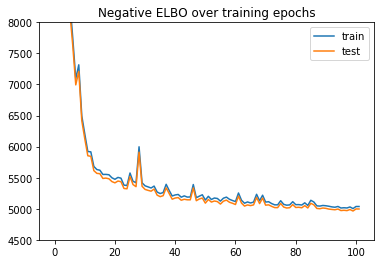

In [11]:
plt.plot(trainer.history["elbo_train_set"], label="train")
plt.plot(trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(4500, 8000)
plt.legend()


## Analyze outputs

We use scanpy to do clustering, umap, visualization after running totalVI. The method `.sequential()` ensures that the ordering of outputs is the same as that in the dataset object.

In [12]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
full_posterior = full_posterior.update({"batch_size":32})

# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background on logits scale, first dataset.nb_genes columns corresponds to ZI probability for genes
py_mixing = sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
)
parsed_protein_names = dataset.protein_names
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)
# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True
)

In [13]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=20, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.3)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.6)

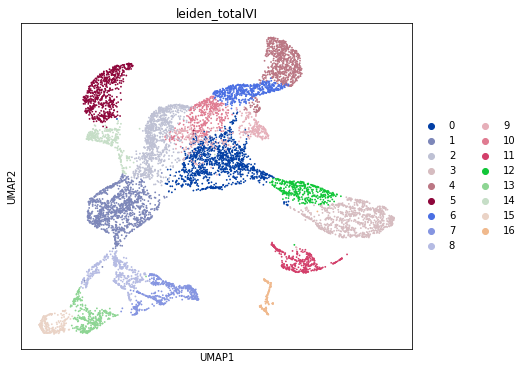

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI"], 
    ax=ax, 
    show=show_plot
)

In [30]:
viz_proteins = ['CD8', "CD19", "CD16", "CD14", "CD69"]

In [20]:
for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{}".format(p)] = denoised_proteins[:, i]

### Visualize denoised protein values 

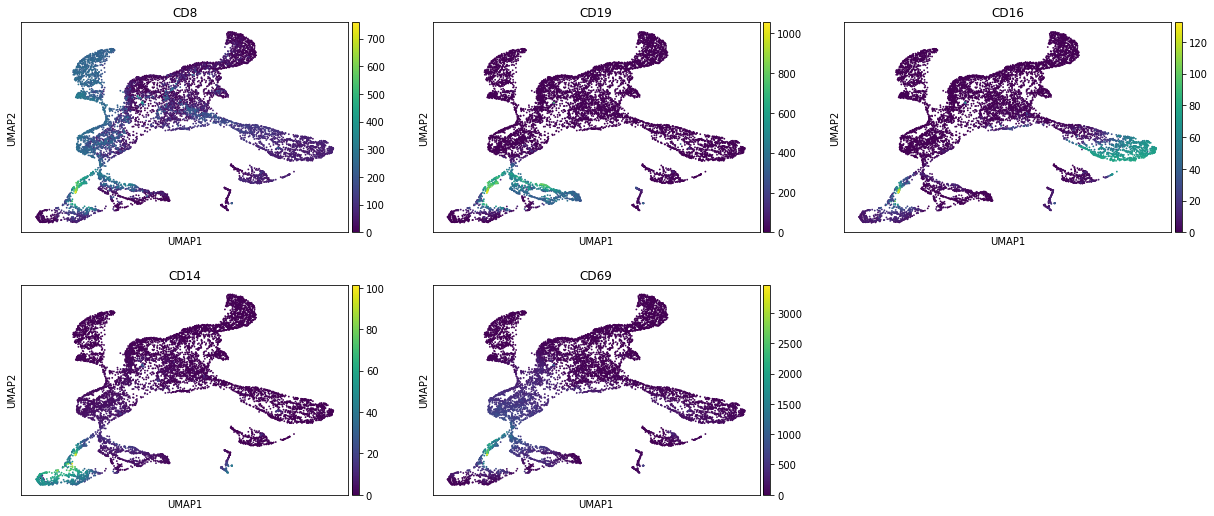

In [31]:
sc.pl.umap(
    post_adata, 
    color=viz_proteins, 
    ncols=3, 
    show=show_plot
)

### Visualize probability of foreground



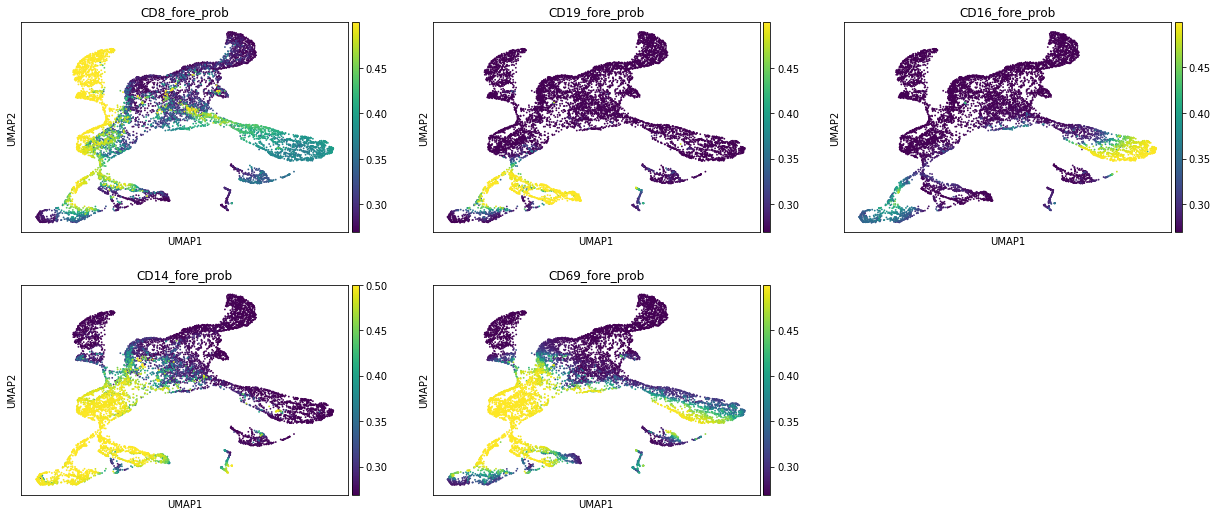

In [32]:
sc.pl.umap(
    post_adata,
    color=["{}_fore_prob".format(p) for p in viz_proteins],
    ncols=3,
    show=show_plot,
)

In [33]:
# Gather all data to export
total_VI_dims = pd.DataFrame(post_adata.obsm["X_totalVI"], columns = ["scVI" + str(s) for s in range(1,21)], index = post_adata.obs.index)
umap_dims = pd.DataFrame(post_adata.obsm["X_umap"], columns = ["UMAP1", "UMAP2"], index = post_adata.obs.index)
barcode_df = pd.DataFrame(dataset.barcodes.tolist(), columns = ["barcode"], index = post_adata.obs.index)
full_df = pd.concat([barcode_df,umap_dims, total_VI_dims,post_adata.obs], axis=1)


In [34]:
full_df.to_csv('../output/13june2020_citeseq_totalVI_output.csv')